In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Data reading and understanding

In [2]:
loan = pd.read_csv('loan.csv')
print(loan.shape)
loan.head()

(39717, 111)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,...,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,...,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,...,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,...,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
4,1075358,1311748,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,...,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan


total columns which have NA values  111
total columns which have NA values greater than 30%  58


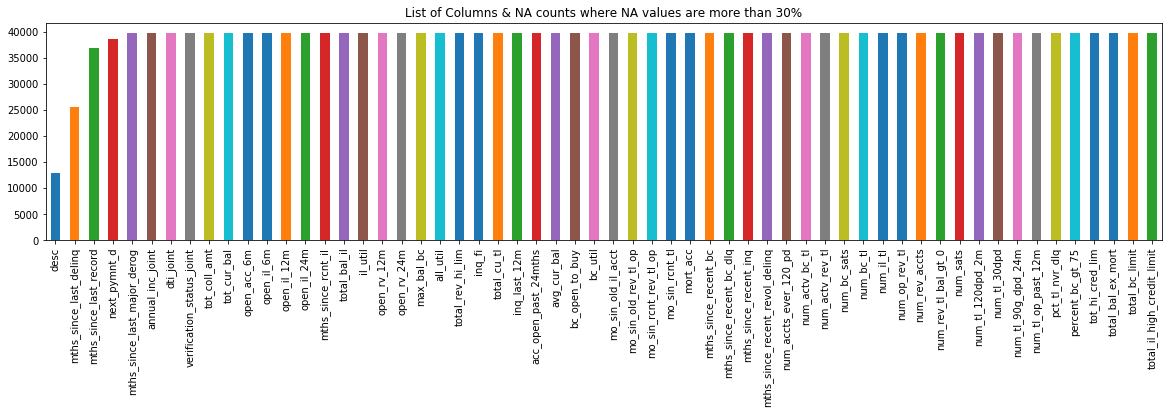

In [3]:
NA_col = loan.isnull().sum()
print("total columns which have NA values ",NA_col.count())

NA_col = NA_col[NA_col.values >(0.3*len(loan))]
print("total columns which have NA values greater than 30% ",NA_col.count())
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('List of Columns & NA counts where NA values are more than 30%')
plt.show()

**Insights:** *So we can see from the above plot that there are 50+ columns in the dataset where all the values are NA.*

As we can see there are 39717 rows & 111 columns in the dataset. We will remove those columns which have more than 30% NA values as it is not feasable to impute missing values for those columns.


# Data Cleaning and Manipulation

In [4]:
def dropNulls(dataframe, axis =1, percent=0.3):
    '''
    * dropNulls function will drop the rows and columns based on parameters provided.
    * dataframe : Name of the dataframe  
    * axis      : axis = 0 defines drop rows, axis =1(default) defines drop columns    
    * percent   : percent of data where column/rows values are null,default is 0.3(30%)
              
    '''
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

**1. Remove columns where NA values are more than or equal to 30%**

In [5]:
loan = dropNulls(loan, axis =1,percent = 0.3)

Number of Columns dropped	:  58

Old dataset rows,columns (39717, 111) 
New dataset rows,columns (39717, 53)


**2. Remove rows where NA values are more than or equal to 30%**

In [6]:
loan = dropNulls(loan, axis =0,percent = 0.3)


Number of Rows dropped	:  0

Old dataset rows,columns (39717, 53) 
New dataset rows,columns (39717, 53)


*There are no rows where NA values are more than or equal to 30%*

**3. Remove columns where number of unique value is only 1.**

*These columns don't have any variance, it cannot help us to determine the reason for default.*

In [7]:
unique = loan.nunique()
unique = unique[unique.values == 1]

print("columns that has only one unique value ",list(unique.index))

loan.drop(labels = list(unique.index), axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")
loan.head()

columns that has only one unique value  ['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
So now we are left with (39717, 44) rows & columns.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.00
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.00
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.00
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.00
4,1075358,1311748,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.00


**4. Remove irrelevant columns.**

*Identify all columns that don’t provide any value. E.g. the url,id's columns*

In [8]:
irrelevant_columns = ["id","member_id","url","zip_code"]
loan.drop(labels = irrelevant_columns, axis =1, inplace=True)
print("So now we are left with",loan.shape ,"rows & columns.")

So now we are left with (39717, 40) rows & columns.


**5. Employment Length : Replace null value with 0.**

In [9]:
print("Before ",loan.emp_length.unique())

loan.emp_length.fillna('0',inplace=True)

print("After ",loan.emp_length.unique())

Before  ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
After  ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' '0']


**6.Employment Title: Replacing - with null to correct like WAL-MART to WALMART**


In [10]:
loan['emp_title'] = loan.emp_title.str.replace('-','')
loan

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.00
1,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.00
2,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.00
3,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.00
4,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.00
5,5000,5000,5000.00,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,...,5632.21,5000.00,632.21,0.00,0.00,0.00,Jan-15,161.03,Jan-16,0.00
6,7000,7000,7000.00,60 months,15.96%,170.08,C,C5,Southern Star Photography,8 years,...,10110.84,6985.61,3125.23,0.00,0.00,0.00,May-16,1313.76,May-16,0.00
7,3000,3000,3000.00,36 months,18.64%,109.43,E,E1,MKC Accounting,9 years,...,3939.14,3000.00,939.14,0.00,0.00,0.00,Jan-15,111.34,Dec-14,0.00
8,5600,5600,5600.00,60 months,21.28%,152.39,F,F2,NaN,4 years,...,646.02,162.02,294.94,0.00,189.06,2.09,Apr-12,152.39,Aug-12,0.00
9,5375,5375,5350.00,60 months,12.69%,121.45,B,B5,Starbucks,< 1 year,...,1469.34,673.48,533.42,0.00,269.29,2.52,Nov-12,121.45,Mar-13,0.00


**7. Remove redundant columns.**

*E.g. The purpose of loan is a drop down which is already a categorical variable. We don’t need the title column as it
becomes redundant.*

In [11]:
print(loan.columns)
loan.drop("title",axis=1,inplace=True)
loan.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

**8. Cast all continuos variables to numeric**

*Cast all continuos variables to numeric so that we can find a correlation between them*

In [12]:
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','int_rate','annual_inc','dti']

loan['int_rate'] = loan.int_rate.str.rstrip('%')

loan[numeric_columns] = loan[numeric_columns].apply(pd.to_numeric)
loan.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
39712,2500,2500,1075.00,36 months,8.07,78.42,A,A4,FiSite Research,4 years,...,1213.88,2500.00,322.97,0.00,0.00,0.00,Jul-10,80.90,Jun-10,nan
39713,8500,8500,875.00,36 months,10.28,275.38,C,C1,"Squarewave Solutions, Ltd.",3 years,...,1020.51,8500.00,1413.49,0.00,0.00,0.00,Jul-10,281.94,Jul-10,nan
39714,5000,5000,1325.00,36 months,8.07,156.84,A,A4,NaN,< 1 year,...,1397.12,5000.00,272.16,0.00,0.00,0.00,Apr-08,0.00,Jun-07,nan
39715,5000,5000,650.00,36 months,7.43,155.38,A,A2,NaN,< 1 year,...,672.66,5000.00,174.20,0.00,0.00,0.00,Jan-08,0.00,Jun-07,nan
39716,7500,7500,800.00,36 months,13.75,255.43,E,E2,Evergreen Center,< 1 year,...,980.83,7500.00,1695.26,0.00,0.00,0.00,Jun-10,256.59,Jun-10,nan


# Derived Metrics

**1. Loan amount to Annual Income ratio**

In [13]:
loan['loan_income_ratio']= loan['loan_amnt']/loan['annual_inc']

**2. Extract Year & Month from Issue date**

In [14]:
loan['issue_month'],loan['issue_year'] = loan['issue_d'].str.split('-', 1).str
loan[['issue_d','issue_month','issue_year']].head()

,issue_d,issue_month,issue_year
0,Dec-11,Dec,11
1,Dec-11,Dec,11
2,Dec-11,Dec,11
3,Dec-11,Dec,11
4,Dec-11,Dec,11


**3. Change order of months from Jan to Dec, currently it's in alphabetical order(A-Z)**

In [15]:
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
loan['issue_month'] = pd.Categorical(loan['issue_month'],categories=months_order, ordered=True)

**4. Create Bins for range of Loan Amount**

In [16]:
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
loan['loan_amnt_range'] = pd.cut(loan['loan_amnt'], bins, labels=slot)

**5. Create Bins for range of Annual Income**

In [17]:
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
loan['annual_inc_range'] = pd.cut(loan['annual_inc'], bins, labels=slot)

#### 6. Create Bins for range of Interest rates

In [18]:
bins = [0, 7.5, 10, 12.5, 15,20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
loan['int_rate_range'] = pd.cut(loan['int_rate'], bins, labels=slot)

# Univariate Analysis #

## Continuous Variables ##
In case of continuous variables, we need to understand the central tendency and spread of the variable.These are measured using various statistical metrics visualization methods such as Boxplot,Histogram/Distribution Plot, Violin Plot etc.

## Categorical Variables ##
For categorical variables, we’ll use frequency table to understand distribution of each category. It can be be measured using two metrics, Count and Count% against each category. Countplot or Bar chart can be used as visualization.

In [19]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[1],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                h = p.get_height()
                if(math.isnan(h)):
                    h=0.01
                ax.annotate('{:1.1f}%'.format((h*100)/float(len(df))), (p.get_x()+0.05, h+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

### Continuous Variables###

**1. Loan Amount**

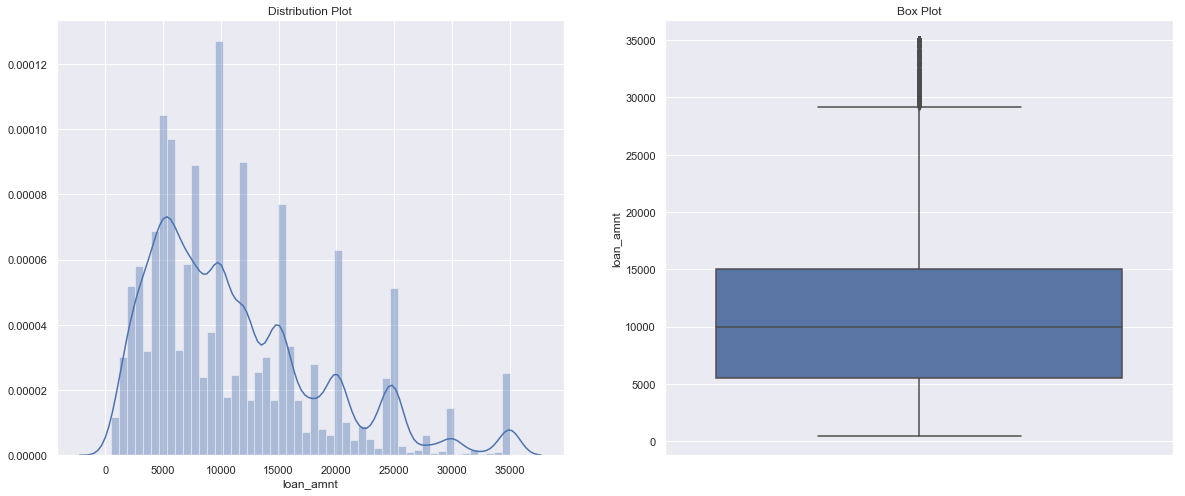

In [20]:
univariate(df=loan,col='loan_amnt',vartype=0)

*Insights: Most of the loan amounts are distributed between 6000 to 15000 USD.*

**2. Interest Rate**

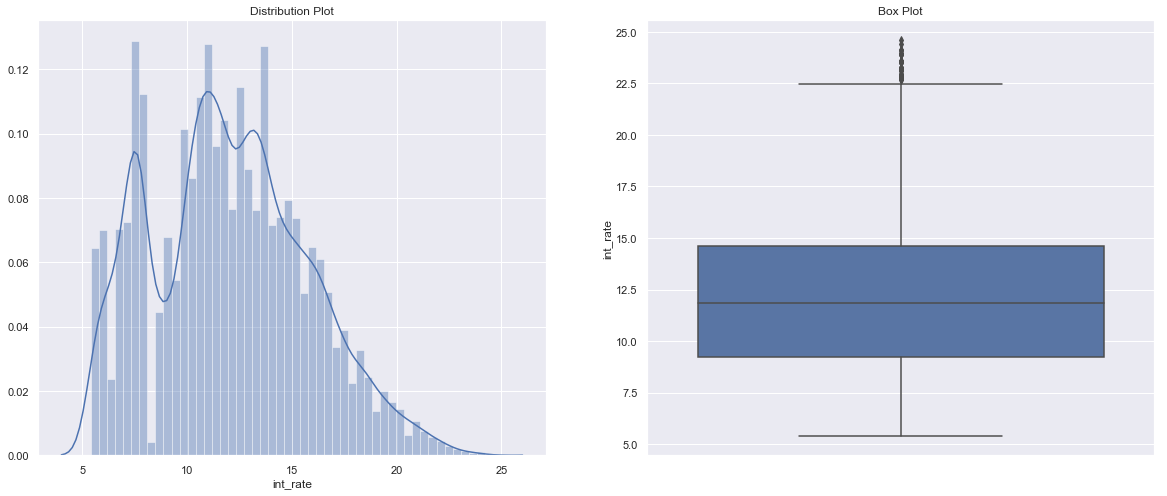

In [21]:
univariate(df=loan,col='int_rate',vartype=0)

*Insights: Most of the loans interest rates are distributed between 9% to 14.5%.*

**3. Annual Income**

In [22]:
loan["annual_inc"].describe()

count     39717.00
mean      68968.93
std       63793.77
min        4000.00
25%       40404.00
50%       59000.00
75%       82300.00
max     6000000.00
Name: annual_inc, dtype: float64

*Max value is 6000000 which is approx 90 times more than mean value, so we will remove the outliers from Annual Income.
Remove Outliers (values from 99 to 100%)*

In [23]:
q = loan["annual_inc"].quantile(0.995)
loan = loan[loan["annual_inc"] < q]
loan["annual_inc"].describe()

count    39494.00
mean     66378.26
std      37413.21
min       4000.00
25%      40000.00
50%      58776.00
75%      81996.00
max     294000.00
Name: annual_inc, dtype: float64

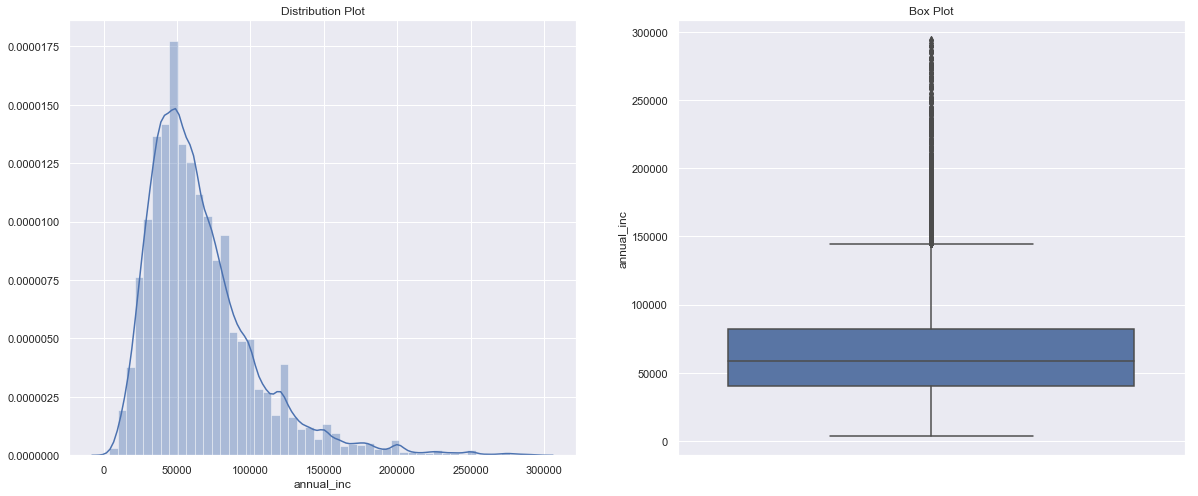

In [24]:
univariate(df=loan,col='annual_inc',vartype=0)

*Insights: Most of the applicants earns beteen 40000 to 80000 USD annually.*

### Categorical Variables###

**4. Loan Status**

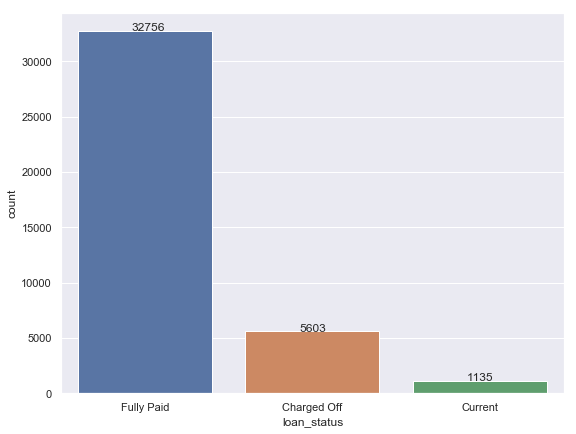

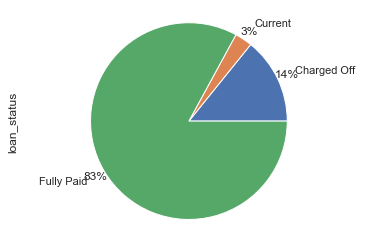

In [25]:
univariate(df=loan,col='loan_status',vartype=1)

loan.loan_status.groupby(loan.loan_status).count().plot(kind='pie',autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')
plt.show()

*Insights: 14% of the applicants Charged off.*

**5. Purpose of loan**

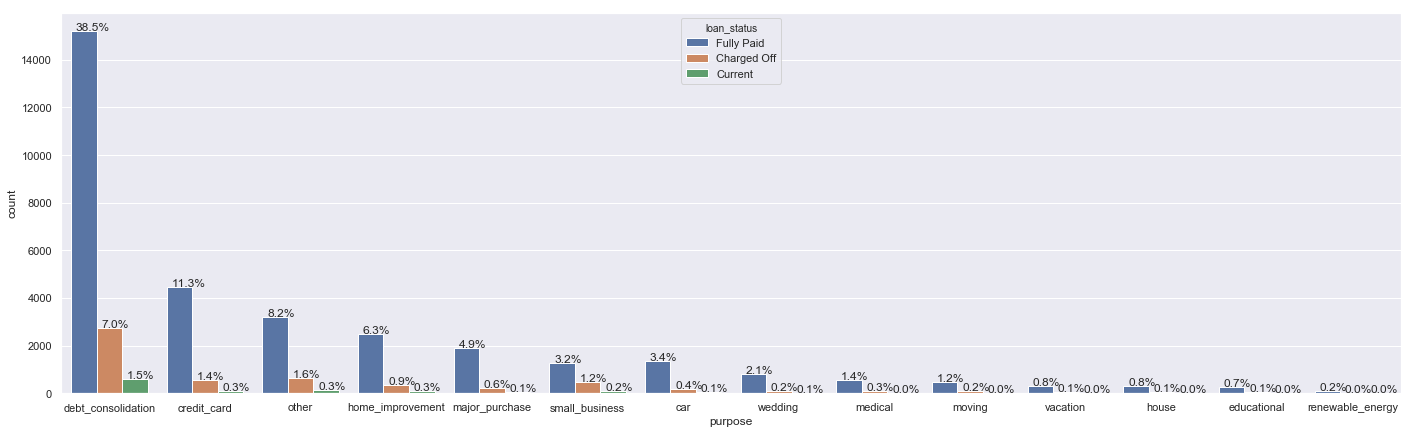

In [26]:
univariate(df=loan,col='purpose',vartype=1,hue='loan_status')

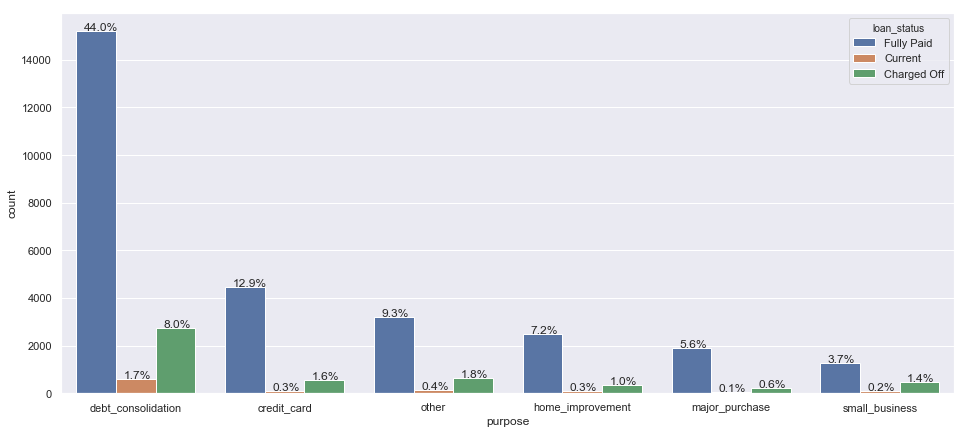

In [27]:

loan = loan[~loan.purpose.isin(['house','renewable_energy','educational','vacation','moving','medical','wedding','car'])]

univariate(df=loan,col='purpose',vartype=1,hue='loan_status')

*Insights: Approx 53% of the applicants applied loan for paying their other loans(Debt Consolidation).*

**6. Home Ownership wise Loan**

In [28]:
loan.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

In [29]:
# Remove rows where home_ownership'=='OTHER', 'NONE', 'ANY'
rem = ['OTHER', 'NONE', 'ANY']
loan.drop(loan[loan.home_ownership.isin(rem)].index,inplace=True)
loan.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE'], dtype=object)

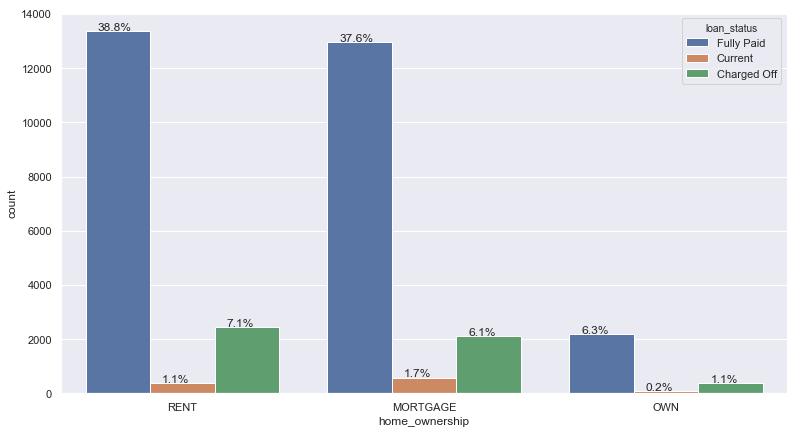

In [30]:
univariate(df=loan,col='home_ownership',vartype=1,hue='loan_status')

*Insights: 47% of applicants are living in rented home whereas 45% applicants were mortagaged their home.*

**7. Year wise Loan**

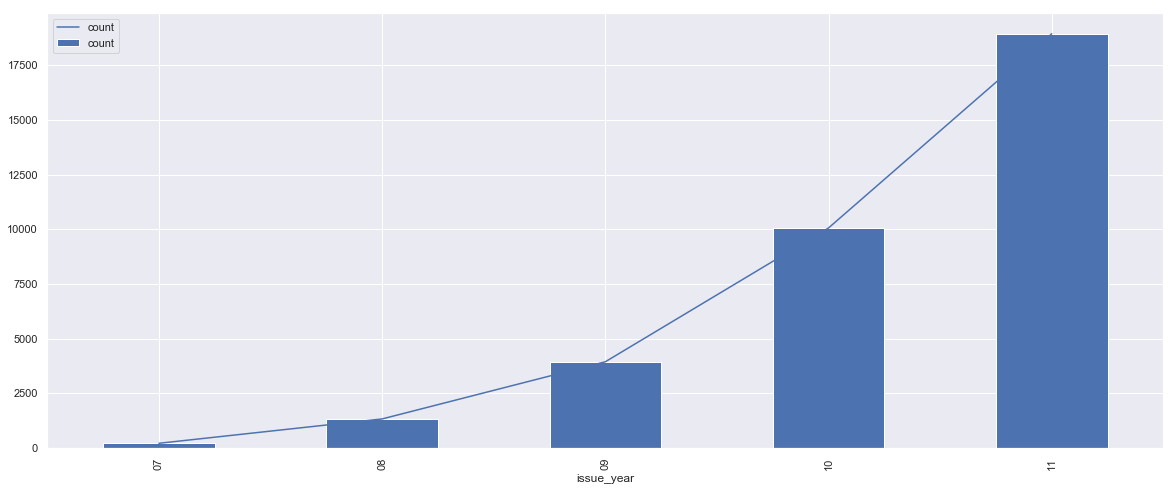

In [31]:
year_wise =loan.groupby(by= [loan.issue_year])[['loan_status']].count()
year_wise.rename(columns={"loan_status": "count"},inplace=True)
ax =year_wise.plot(figsize=(20,8))
year_wise.plot(kind='bar',figsize=(20,8),ax = ax)
plt.show()

*Insights: loan applicants are increasing year on year*

**8. Loan Term**

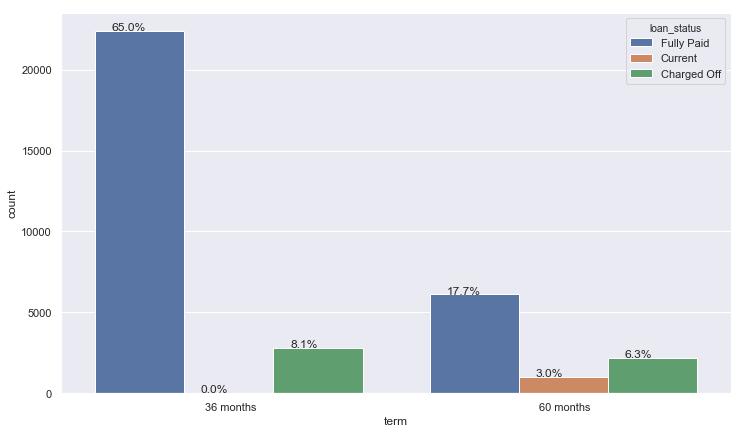

In [32]:
univariate(df=loan,col='term',vartype=1,hue='loan_status')

*Insights: 73% of applicants applied loan for 36 months term period.*

# Bivariate/Multivariate Analysis #
Bivariate/Multivariate Analysis finds out the relationship between two/two or more variables.We can perform Bivariate/Multivariate analysis for any combination of categorical and continuous variables. The combination can be: Categorical & Categorical, Categorical & Continuous and Continuous & Continuous.

**1. Purpose of Loan vs Loan Amount for each Loan Status**

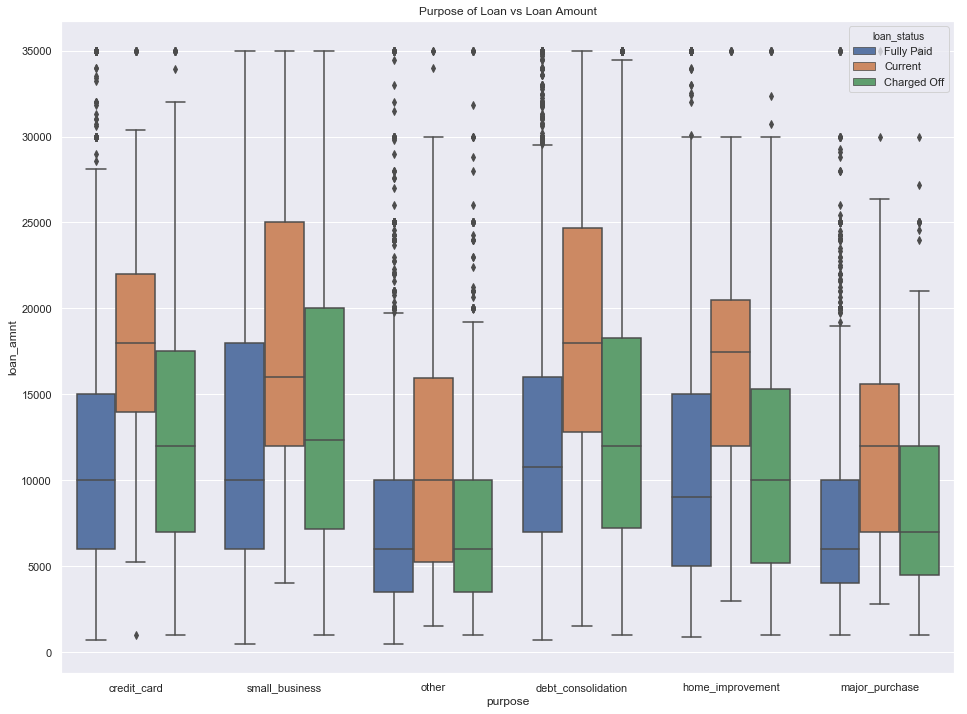

In [33]:
plt.figure(figsize=(16,12))
sns.boxplot(data =loan, x='purpose', y='loan_amnt', hue ='loan_status')
plt.title('Purpose of Loan vs Loan Amount')
plt.show()

*Insight : small business are having more number of chanrge off*

**2. Correlation Matrix : All Continuos(Numeric) Variables**

In [34]:
col = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'addr_state',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'loan_income_ratio', 'issue_month',
       'issue_year', 'loan_amnt_range', 'annual_inc_range', 'int_rate_range']
loan_corr = loan[col]
loan_correlation = loan_corr.corr()
loan_correlation

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,open_acc,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,loan_income_ratio
loan_amnt,1.00,0.98,0.94,0.31,0.93,0.42,0.17,0.32,0.26,0.19,0.19,0.88,0.85,0.84,0.73,0.44,0.61
funded_amnt,0.98,1.00,0.96,0.32,0.95,0.42,0.17,0.31,0.25,0.20,0.20,0.90,0.87,0.86,0.74,0.45,0.60
funded_amnt_inv,0.94,0.96,1.00,0.31,0.90,0.40,0.16,0.29,0.24,0.20,0.20,0.88,0.91,0.84,0.73,0.44,0.57
int_rate,0.31,0.32,0.31,1.00,0.29,0.08,0.01,0.10,-0.04,0.14,0.14,0.31,0.31,0.18,0.54,0.16,0.22
installment,0.93,0.95,0.90,0.29,1.00,0.42,0.17,0.31,0.23,0.12,0.12,0.85,0.81,0.84,0.63,0.40,0.55
annual_inc,0.42,0.42,0.40,0.08,0.42,1.00,0.25,0.43,0.37,0.06,0.06,0.40,0.39,0.40,0.29,0.22,-0.32
open_acc,0.17,0.17,0.16,0.01,0.17,0.25,1.00,0.28,0.68,0.03,0.03,0.16,0.15,0.16,0.12,0.08,-0.04
revol_bal,0.32,0.31,0.29,0.10,0.31,0.43,0.28,1.00,0.30,0.06,0.06,0.29,0.28,0.28,0.24,0.12,-0.00
total_acc,0.26,0.25,0.24,-0.04,0.23,0.37,0.68,0.30,1.00,0.03,0.03,0.23,0.22,0.23,0.15,0.16,-0.05
out_prncp,0.19,0.20,0.20,0.14,0.12,0.06,0.03,0.06,0.03,1.00,1.00,0.24,0.25,0.17,0.39,-0.07,0.13


**3. HeatMap: All continuos variables¶**

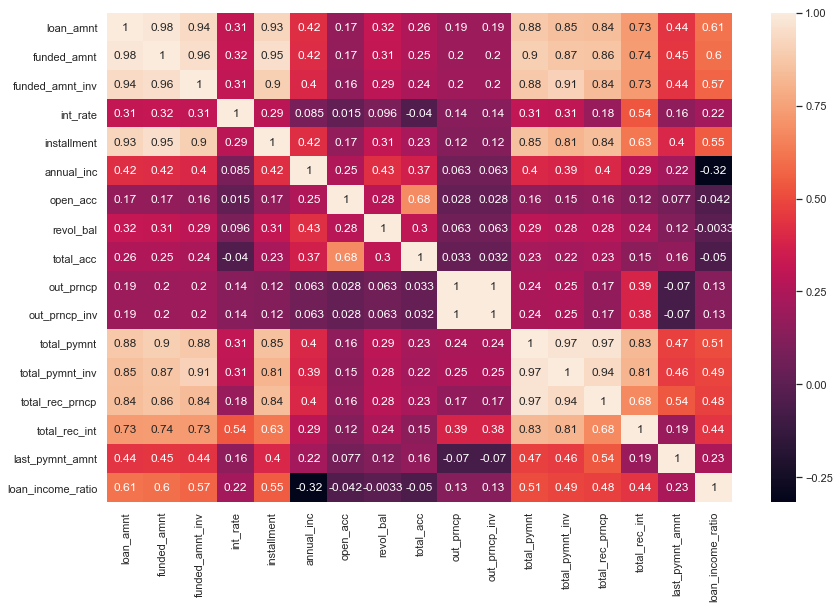

In [35]:
# need to change color dark to light
f, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= True)
plt.show()

*Insights: It is clear from the Heatmap that how 'loan_amnt','funded_amnt' & 'funded_amnt_inv' are closely interrelated.So we can take any one column out of them for our analysis.*

**4. Employment Length vs Loan Amount for different pupose of Loan**

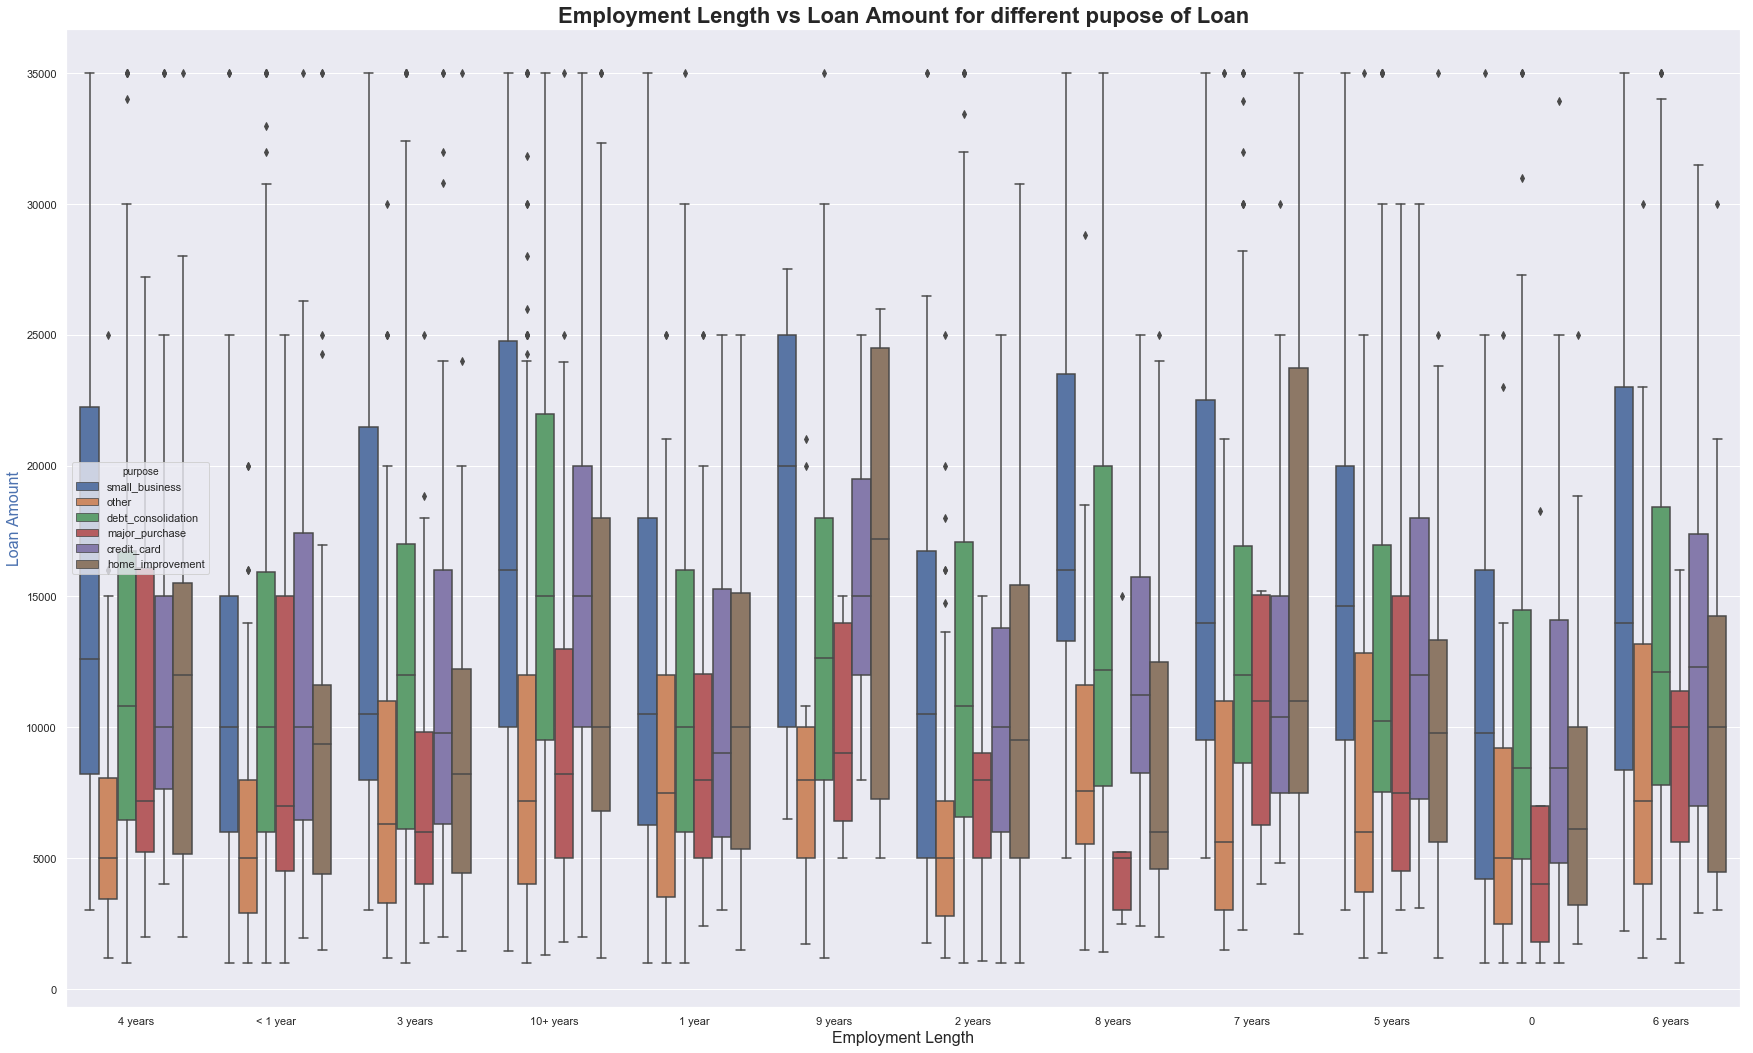

In [36]:
loanstatus=loan.pivot_table(index=['loan_status','purpose','emp_length'],values='loan_amnt',aggfunc=('count')).reset_index()
loanstatus=loan.loc[loan['loan_status']=='Charged Off']

ax = plt.figure(figsize=(30, 18))
ax = sns.boxplot(x='emp_length',y='loan_amnt',hue='purpose',data=loanstatus)
ax.set_title('Employment Length vs Loan Amount for different pupose of Loan',fontsize=22,weight="bold")
ax.set_xlabel('Employment Length',fontsize=16)
ax.set_ylabel('Loan Amount',color = 'b',fontsize=16)
plt.show()

# Bivariate/Multivariate Analysis with Probability of Charge off #
Categorical Variables vs Probability of Charged Off
The main motive of this use case to find what parameters are impacting the most on Loan Status that is if a applicant will successfully complete the loan term or will charge off.

So we will be using a new term now Probability of Charged Off that will be equal to :

\begin{equation*}
{Probability\:of\:Charged\:Off =\:}\frac{Number\:of\:Applicants\:who\:charged\:off}{Total\:No.\:of\:Applicants}
\end{equation*}
 
We will calculate this probability w.r.t each column in bivariate analysis & will see how the Probability of Charged Off changes with these columns.

We will create a user defined function for this.

In [37]:
def crosstab(df,col):
    '''
    This function will be used to get the summarized table for each column(passed as a variable) 
    along with probability of charge off w.r.t that column.
    df : Dataframe
    col: Column Name
    '''
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Charged_Off'] = round((crosstab['Charged Off']/crosstab['All']),3)
    crosstab = crosstab[0:-1]
    return crosstab

# Probability of charge off
def bivariate_prob(df,col,stacked= True):
    '''
    function will be used to plot count of values for each column(passed as a variable) stacked across
    loan_status along with probability of charged off as a line chart.
    df      : Dataframe
    col     : Column Name
    stacked : True(default) for Stacked Bar
    '''
    # get dataframe from crosstab function
    plotCrosstab = crosstab(df,col)
    
    linePlot = plotCrosstab[['Probability_Charged_Off']]      
    barPlot =  plotCrosstab.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'b')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(),fontsize=14)
    ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
    plt.show()

**1. Location vs Probability Charge Off**

In [38]:
filter_states = loan.addr_state.value_counts()
filter_states = filter_states[(filter_states < 10)]

loan_filter_states = loan.drop(labels = loan[loan.addr_state.isin(filter_states.index)].index)
states = crosstab(loan_filter_states,'addr_state')

print(states.Probability_Charged_Off.sort_values(ascending=False).head(5))

display(states.head(20))

addr_state
NV   0.22
SD   0.20
FL   0.18
NM   0.17
MO   0.17
Name: Probability_Charged_Off, dtype: float64


loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged_Off
addr_state,,,,,
AK,12,2,59,73,0.16
AL,49,16,336,401,0.12
AR,20,9,185,214,0.09
AZ,104,26,619,749,0.14
CA,987,135,5073,6195,0.16
CO,88,23,570,681,0.13
CT,88,23,544,655,0.13
DC,14,3,169,186,0.07
DE,12,1,86,99,0.12


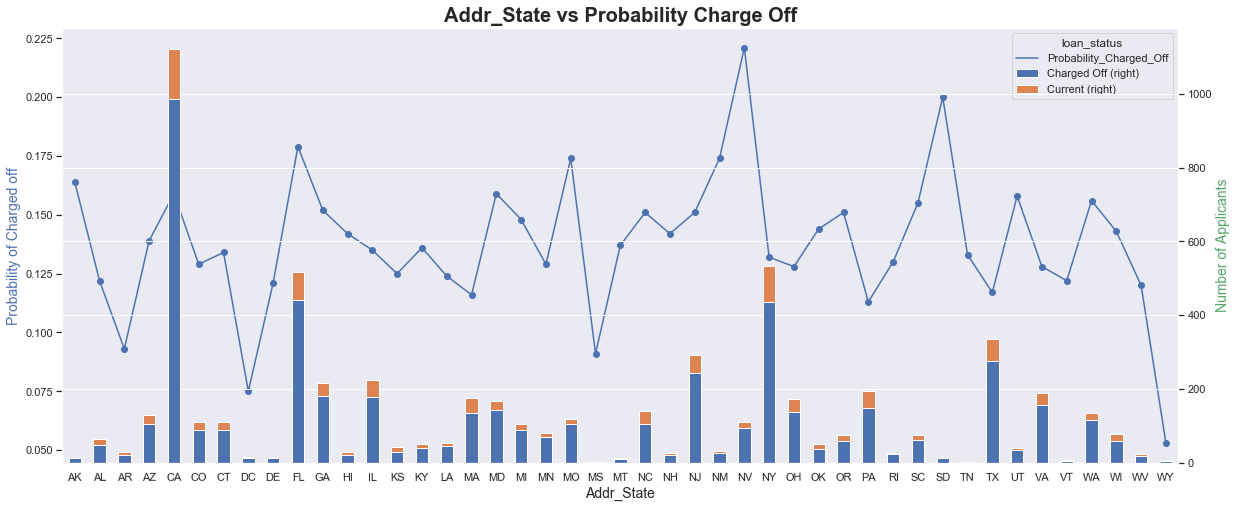

In [39]:
bivariate_prob(df =loan_filter_states,col ='addr_state')

*Insights: There are multiple States/Provinces with high probability of charge,highest being 'NV' at 0.22*

**2. Purpose of Loan vs Probability Charge Off**

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged_Off
purpose,,,,,
credit_card,539,103,4457,5099,0.11
debt_consolidation,2753,585,15181,18519,0.15
home_improvement,340,99,2479,2918,0.12
major_purchase,220,37,1912,2169,0.10
other,628,127,3206,3961,0.16
small_business,469,74,1262,1805,0.26


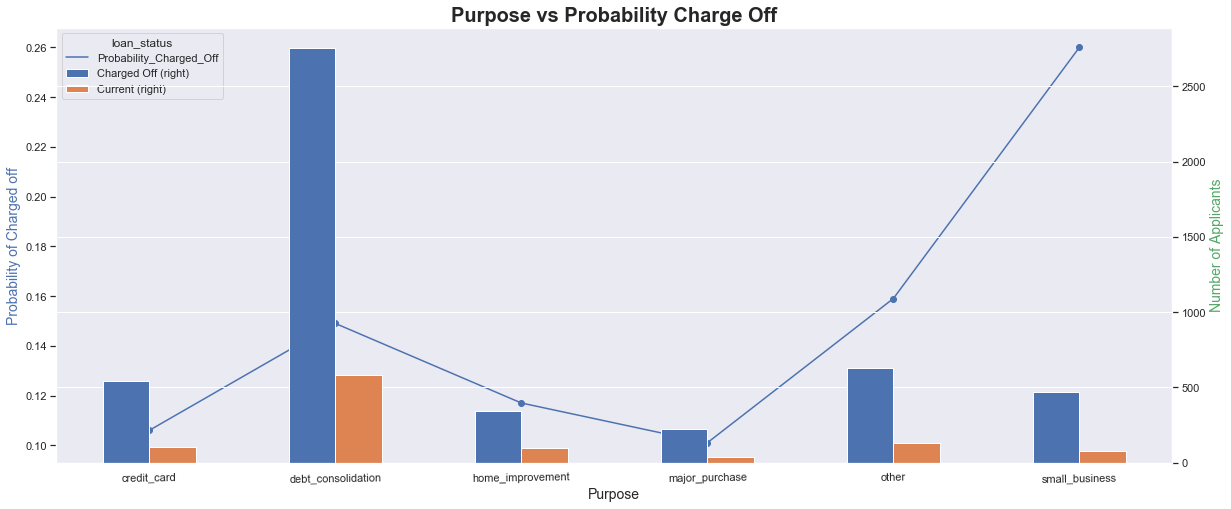

In [40]:
purpose = crosstab(loan,'purpose')
display(purpose)

bivariate_prob(df =loan,col ='purpose',stacked=False)

*Insights: Applicants who has taken the Loan for 'small business' has the highest probabilty of charge off of 26%. So bank should take extra caution like take some asset or guarentee while approving the loan for purpose of 'small business'*  

**3. Grade/Subgrade vs Probability Charge Off**

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged_Off
grade,,,,,
A,505,34,7914,8453,0.06
B,1208,299,8894,10401,0.12
C,1194,237,5663,7094,0.17
D,1010,201,3517,4728,0.21
E,650,171,1734,2555,0.25
F,293,68,597,958,0.31
G,89,15,178,282,0.32


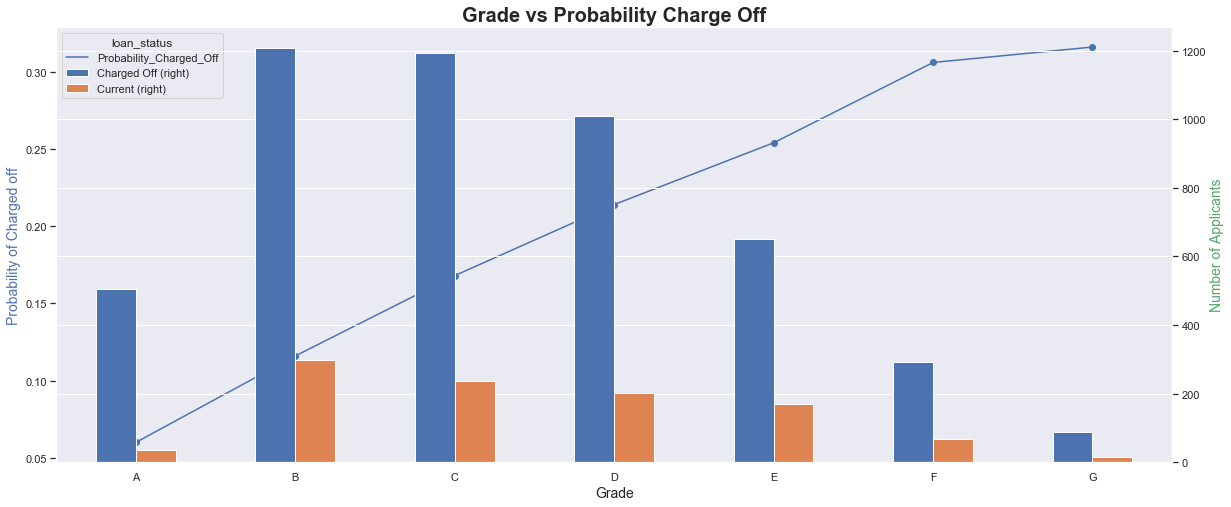

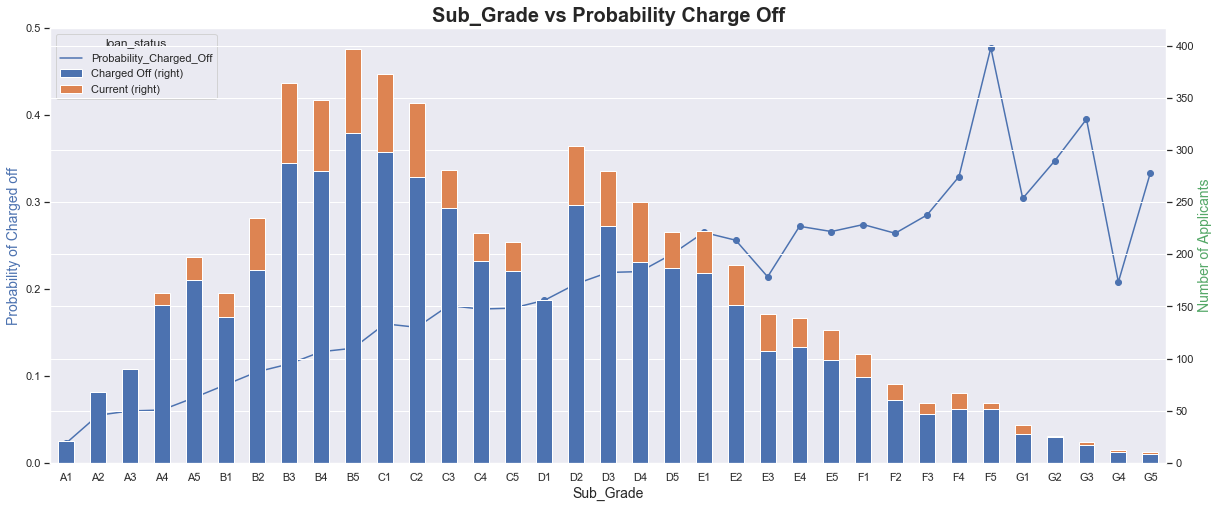

In [41]:
grade = crosstab(loan,'grade')
display(grade)

bivariate_prob(df =loan,col ='grade',stacked=False)
bivariate_prob(df =loan,col ='sub_grade')

*Insights: As we move from Grade A to G, probability that person will charged off is increasing.*

**4. Annual Income Range vs Probability Charge Off**

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged_Off
annual_inc_range,,,,,
0-25000,410,23,1683,2116,0.19
25000-50000,1856,290,9231,11377,0.16
50000-75000,1517,321,8719,5573,0.27
75000-100000,655,205,4713,10557,0.06
100000 and above,511,186,4151,4848,0.10


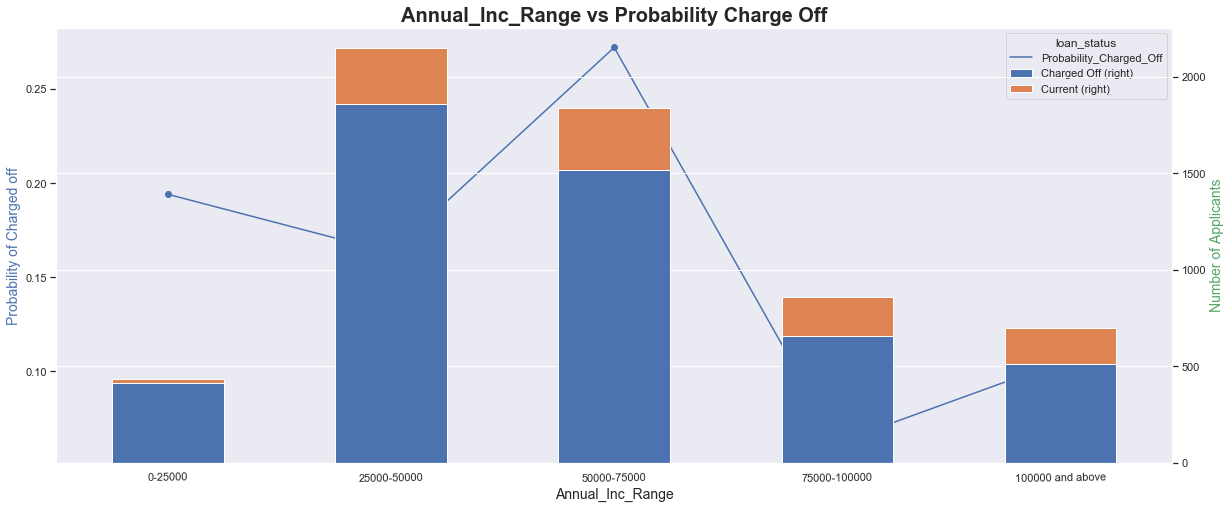

In [42]:
annual_inc_range = crosstab(loan,'annual_inc_range')
display(annual_inc_range)

bivariate_prob(df =loan,col ='annual_inc_range')

*Insights: The probability that person will default is highest of 25% at (50000 to 75000) salary bracket.*

**5. Interest rate Range vs Probability Charge Off**

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged_Off
int_rate_range,,,,,
0-7.5,219,6,4268,6849,0.03
7.5-10,474,54,5390,8046,0.06
10-12.5,1044,236,7089,4493,0.23
12.5-15,1326,236,6484,8369,0.16
15 and above,1615,399,4835,5918,0.27


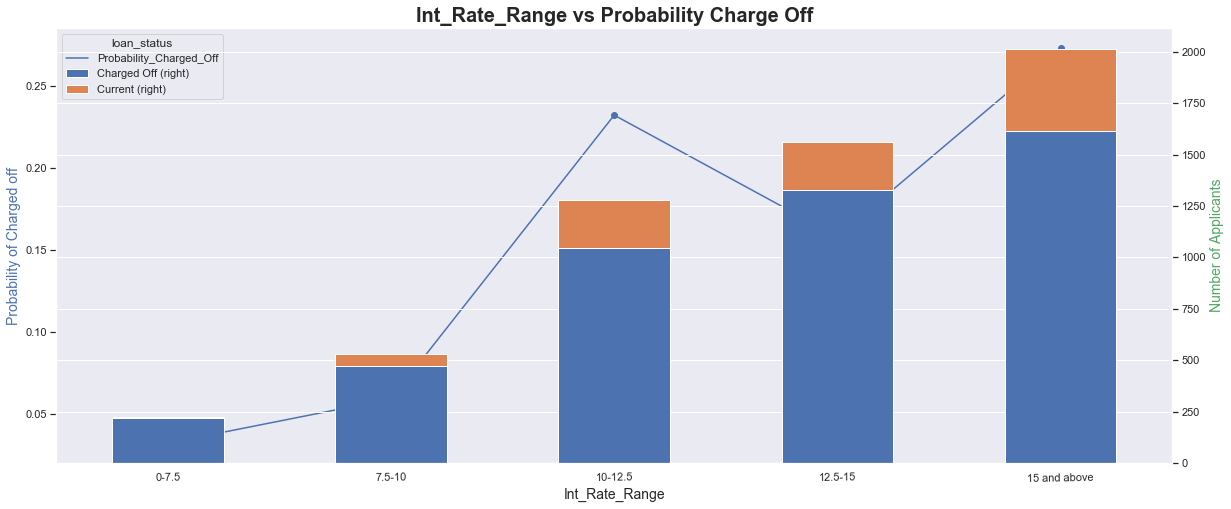

In [43]:
int_rate_range = crosstab(loan,'int_rate_range')
display(int_rate_range)

bivariate_prob(df =loan,col ='int_rate_range')

*Insights: As the interest rate is increasing the probability that person will default is increasing with highest of 28% at 15 & above bracket.*

#### 6. Employment Length vs Probability Charge Off

loan_status,Charged Off,Current,Fully Paid,All,Probability_Charged_Off
emp_length,,,,,
0,198,39,664,901,0.22
1 year,397,59,2302,2758,0.14
10+ years,1200,357,6309,7866,0.15
2 years,494,82,3213,3789,0.13
3 years,486,75,2970,3531,0.14
4 years,399,88,2488,2975,0.13
5 years,404,79,2362,2845,0.14
6 years,275,53,1627,1955,0.14
7 years,227,59,1270,1556,0.15


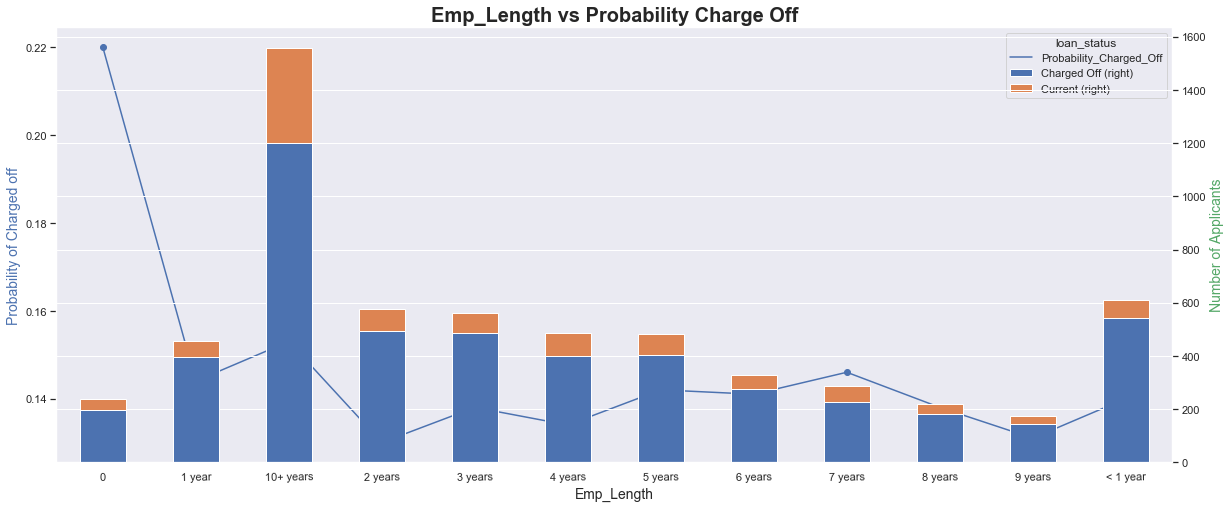

In [44]:
emp_length = crosstab(loan,'emp_length')
display(emp_length)

bivariate_prob(df =loan,col ='emp_length')

*Insights: Applicants who are less than 1 year of experience are more probable of charged off..*